In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 

from povm_clf import *

---
# Circuit Diagrams

## State preparation circuit

In [2]:
test = SingleQubitPOVM(bloch_vec=[0.7,0,0])
@qml.qnode(qml.device('default.qubit', wires=2))
def circ_test():
    test.state_prepared_on_circuit(wires=[0,1]) #요거 그림 그려보기!
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0, 0]
Output Bloch vector =  [ 7.01060417e-01 -7.15448720e-04  2.88136914e-04]


In [3]:
diagram = qml.draw(circ_test)
print(diagram())

 0: ──Rot(0.192, -1.57, 4.74)─────╭C──Rot(3.12, 1.43, 4.71)──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──Rot(-0.119, -1.01, -0.596)──╰X──Rot(2.41, 2.67, 5.28)──╰┤ ⟨Z ⊗ Z⟩ 



## n-element POVM circuit

In [ ]:
n = 3
devs = [qml.device('default.qubit', wires=n), qml.device('default.qubit', wires=n)]
wires = [0, 1, 2]
bloch_vecs = [[0,0,0.7], [0,0,-0.7]]
params = 2 * np.pi * np.random.random([(3 + 8 * 2)])


@qml.qnode(devs[0])
def circ_test1(params, wires):
    state_prepared(wires=[wires[0], wires[-1]])
    SingleQubitPOVM().first_U(params[:3], wire=wires[0])
    SingleQubitPOVM().two_element_povm(params[3:], wires=[wires[0],wires[1]])

    return qml.probs(wires=wires[1])

circ_test1(params=params, wires=wires)
print(circ_test1.draw())

---
# Pure-state Classifier

##  Two-element POVM

In [6]:
n = 2
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1]
bloch_vecs = [[1,0,0], [-1,0,0]]

In [7]:
classifier = POVM_clf(2, wires, bloch_vecs, dev)
Helstrom_bound = classifier.spectral_decomp()

In [8]:
cost_list = classifier.run_opt(steps=100)

Cost(init_params)    :  0.4760694
Cost after step    20:  0.1443643
Cost after step    40:  0.0021662
Cost after step    60:  0.0000320
Cost after step    80:  0.0000005
Cost after step   100:  0.0000000


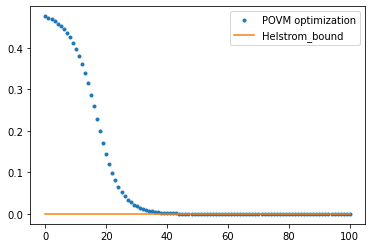

In [9]:
plt.plot(list(range(101)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(101)), [Helstrom_bound]*101, '-', label="Helstrom_bound")
plt.legend()
plt.show()

In [10]:
E = classifier.povm()
rho = classifier.density_matrices
print(E)
rho

(tensor([[0.5       +0.00000000e+00j, 0.49999999-3.79276262e-09j],
        [0.49999999+3.79276262e-09j, 0.49999999+0.00000000e+00j]], requires_grad=True), tensor([[ 0.5       +0.00000000e+00j, -0.49999999+3.79276269e-09j],
        [-0.49999999-3.79276269e-09j,  0.50000001+0.00000000e+00j]], requires_grad=True))


[tensor([[0.5+0.j, 0.5+0.j],
         [0.5+0.j, 0.5+0.j]], requires_grad=True),
 tensor([[ 0.5+0.j, -0.5+0.j],
         [-0.5+0.j,  0.5+0.j]], requires_grad=True)]

## Three-element POVM

In [11]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]

In [12]:
classifier = POVM_clf(n, wires, bloch_vecs, dev)
#Helstrom_bound = classifier.spectral_decomp()

In [13]:
steps = 300
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.6828178
Cost after step    20:  0.6227101
Cost after step    40:  0.4983709
Cost after step    60:  0.3998543
Cost after step    80:  0.3752633
Cost after step   100:  0.3648510
Cost after step   120:  0.3536371
Cost after step   140:  0.3431094
Cost after step   160:  0.3369534
Cost after step   180:  0.3344866
Cost after step   200:  0.3336768
Cost after step   220:  0.3334341
Cost after step   240:  0.3333639
Cost after step   260:  0.3333433
Cost after step   280:  0.3333370
Cost after step   300:  0.3333348


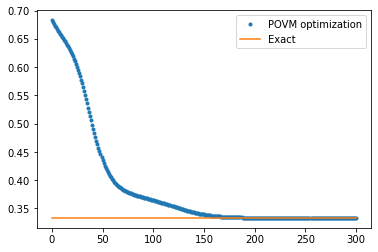

In [14]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(steps+1)), [1/3]*(steps+1), '-', label="Exact")
plt.legend()
plt.show()

In [15]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices
E

(tensor([[ 0.33260787+0.j        , -0.16747059+0.28736775j],
         [-0.16747059-0.28736775j,  0.33260373+0.j        ]], requires_grad=True),
 tensor([[0.33472219+0.j        , 0.33472315+0.00020235j],
         [0.33472315-0.00020235j, 0.33472424+0.j        ]], requires_grad=True),
 tensor([[ 0.33266994+0.j       , -0.16725256-0.2875701j],
         [-0.16725256+0.2875701j,  0.33267202+0.j       ]], requires_grad=True))

Bloch Sphere visualization for both initial qubit and measurment direction

---
# Mixed-state Classifier

## Two-element POVM

In [23]:
n = 2
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2]
bloch_vecs = [[0.2,0,0], [-0.2,0,0]]

In [24]:
classifier = POVM_clf(2, wires, bloch_vecs, devs)
Helstrom_bound_exact = classifier.spectral_decomp()
Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.2, 0, 0]
Output Bloch vector =  [ 0.20009325 -0.00021131  0.00180862]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.2, 0, 0]
Output Bloch vector =  [-2.00473033e-01 -7.87159817e-05  2.73090140e-03]


In [25]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.4952658
Cost after step    20:  0.4916201
Cost after step    40:  0.4844267
Cost after step    60:  0.4706704
Cost after step    80:  0.4490980
Cost after step   100:  0.4267059
Cost after step   120:  0.4122001
Cost after step   140:  0.4052332
Cost after step   160:  0.4021997
Cost after step   180:  0.4008877
Cost after step   200:  0.4003137
Cost after step   220:  0.4000604
Cost after step   240:  0.3999481
Cost after step   260:  0.3998982
Cost after step   280:  0.3998760
Cost after step   300:  0.3998661
Cost after step   320:  0.3998617
Cost after step   340:  0.3998597
Cost after step   360:  0.3998589
Cost after step   380:  0.3998585
Cost after step   400:  0.3998583


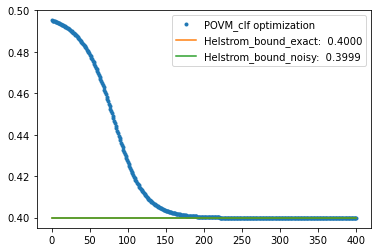

In [26]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [27]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices

In [28]:
1-(1/2)*sum([np.trace(np.dot(E[i], rho[i])) for i in range(2)])

(0.4000004084701315+0j)

## Three-element POVM

In [57]:
n = 3
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2, 3]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
bloch_vecs = [[0.7 * bloch_vecs[n][i] for i in range(3)] for n in range(n)]

In [60]:
i=0
np.sqrt(np.dot(bloch_vecs[i], bloch_vecs[i]))

0.7

In [61]:
classifier = POVM_clf(3, wires, bloch_vecs, devs)
#Helstrom_bound_exact = classifier.spectral_decomp()
#Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3499999999999998, 0.6062177826491071, -1.1256858547736456e-16]
Output Bloch vector =  [-0.35012612  0.60478534 -0.00108377]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0.0, -1.1256858547736456e-16]
Output Bloch vector =  [ 6.99685197e-01 -3.71520512e-03 -4.32940196e-04]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3499999999999998, -0.6062177826491071, -1.1256858547736456e-16]
Output Bloch vector =  [-0.34926078 -0.60618612  0.00419005]


In [62]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.6517105
Cost after step    20:  0.6159763
Cost after step    40:  0.5345015
Cost after step    60:  0.4855346
Cost after step    80:  0.4725027
Cost after step   100:  0.4683831
Cost after step   120:  0.4666586
Cost after step   140:  0.4658399
Cost after step   160:  0.4654338
Cost after step   180:  0.4652269
Cost after step   200:  0.4651178
Cost after step   220:  0.4650571
Cost after step   240:  0.4650207
Cost after step   260:  0.4649967
Cost after step   280:  0.4649793
Cost after step   300:  0.4649656
Cost after step   320:  0.4649542
Cost after step   340:  0.4649443
Cost after step   360:  0.4649355
Cost after step   380:  0.4649277
Cost after step   400:  0.4649205


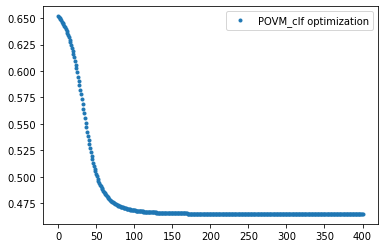

In [63]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
#plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
#plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

---
# For various purities $\mathcal{P}$,

$\hat{\rho} = \frac{1}{2}(I+\vec{a}\cdot\hat{\sigma})$ <br>
$
\mathcal{P} = Tr[\hat{\rho}^2] = \frac{1}{2}(1+|\vec{a}|^2) \Longrightarrow
|\vec{a}| = \sqrt{2\mathcal{P}-1}
$ 

## Case 1
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (-\sqrt{2\mathcal{P}-1}, 0, 0)$

In [ ]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
ampltd_abs = [1, 0.7, 0.4, 0.1]
#Pure state


#Mixed state
steps = [100, 150, 200, 400]
for i, a in enumerate(ampltd_abs):
    
    bloch_vecs = [[a,0,0], [(-1)*a,0,0]]
    if a == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

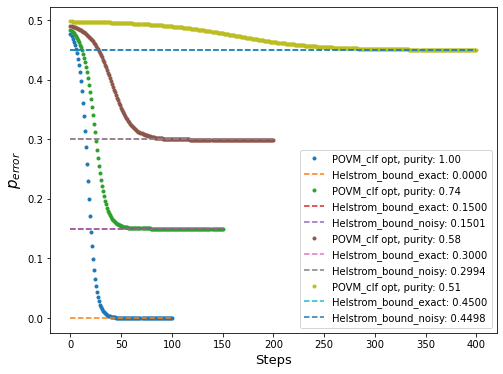

In [14]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="POVM_clf opt, purity:{: .2f}".format((ampltd_abs[i]**2+1)/2))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_exact: {:.4f}".format(Hbe_list[i]))
    if i !=0:
        plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_noisy: {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$p_{error}$', fontsize=15)
plt.legend()
plt.savefig('result1.png', bbox_inches='tight', transparent=True)
plt.show()

## Case 2
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (0, 0, \sqrt{2\mathcal{P}-1})$

In [ ]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
purities = [1, 0.85, 0.7, 0.55]


steps = [130, 170, 250, 500]
for i, p in enumerate(purities):
    
    bloch_vecs = [[np.sqrt(2*p-1),0,0], [0,0,np.sqrt(2*p-1)]]
    if p == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

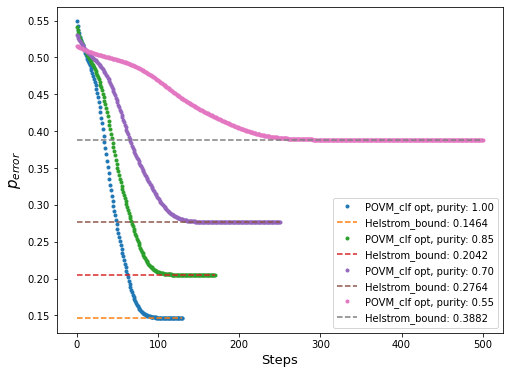

In [86]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="POVM_clf opt, purity:{: .2f}".format((purities[i])))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound: {:.4f}".format(Hbe_list[i]))
    #if i !=0:
    #    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound, "+r"$\rho_{noisy}$"+": {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$p_{error}$', fontsize=15)
plt.legend()
plt.savefig('result2.png', bbox_inches='tight', transparent=True)
plt.show()

## Case 3
$|\psi_0\rangle = \left(|0\rangle + e^{2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_0=\sqrt{2\mathcal{P}-1}(-1/2, \sqrt{3}/2, 0)$<br>
$|\psi_1\rangle = \left(|0\rangle+|1\rangle\right)/\sqrt{2}$       ========> $\vec{a}_1 = \sqrt{2\mathcal{P}-1}(1,0,0) $ <br>
$|\psi_2\rangle = \left(|0\rangle + e^{-2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_2 = \sqrt{2\mathcal{P}-1}(-1/2, -\sqrt{3}/2, 0)$

In [ ]:
n_qubit = 4
wires = [0, 1, 2, 3]
n_outcome = 3
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list= []
purities = [1, 0.85, 0.7, 0.55]
steps = [250, 300, 350, 400]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
bloch_vecs = [[np.sqrt(2*p-1) * bloch_vecs[n][i] for i in range(3)] for n in range(n)]
for i, p in enumerate(purities):    

    if p == 1:
        classifier =POVM_clf(3, wires[:3], bloch_vecs, devs[:3])
        cost_list.append(classifier.run_opt(steps[i]))

    else:
        classifier = POVM_clf(3, wires, bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))

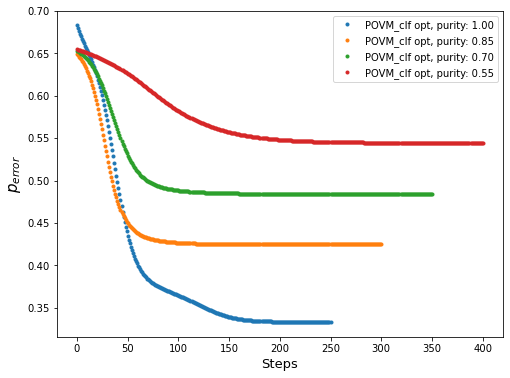

In [84]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="POVM_clf opt, purity:{: .2f}".format((purities[i])))

plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$p_{error}$', fontsize=15)
plt.legend()
plt.savefig('result3png', bbox_inches='tight', transparent=True)
plt.show()

그래프 조금 더 다듬기

---
---
---
# Test

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 

from povm_clf import *

In [2]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n#, qml.device('default.qubit', wires=n), qml.device('default.qubit', wires=n)] 
wires = [0, 1, 2]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)] 

In [3]:
np.random.seed(2)
params = 4 * np.pi * np.random.random([19])
params

tensor([ 5.47887353,  0.32579864,  6.90726241,  5.47042252,  5.2824976 ,
         4.15110979,  2.57169058,  7.78198847,  3.76557169,  3.35305043,
         7.80539794,  6.64939566,  1.69118147,  6.45381301,  2.31773971,
         9.86881252, 10.73137002,  6.21076327, 10.63820537], requires_grad=True)

In [8]:
params_opt = np.array([2.07716568, 7.85397763, 0.5236459 , 3.14159269, 1.23291917,
        1.59793933, 7.49892272, 2.84015056, 1.0471506 , 1.59700472,
        4.39604675, 6.28317501, 3.14158859, 8.04758825, 6.07043459,
        6.34899187, 4.86183644, 9.97314239, 7.28854747])
classifier = POVM_clf(n, wires, bloch_vecs, dev)
classifier.cost_fn(params), classifier.cost_fn(params_opt)

[8.18281620e-01 4.81482486e-35 1.22542914e-01 5.91754651e-02]
[7.98603265e-01 2.04630057e-34 1.52876822e-01 4.85199128e-02]
[8.03528796e-01 4.81952684e-35 1.60807782e-01 3.56634215e-02]


(0.6617490587001609, 0.4986002199858599)

In [9]:
classifier.povm_params

tensor([ 5.47887353,  0.32579864,  6.90726241,  5.47042252,  5.2824976 ,
         4.15110979,  2.57169058,  7.78198847,  3.76557169,  3.35305043,
         7.80539794,  6.64939566,  1.69118147,  6.45381301,  2.31773971,
         9.86881252, 10.73137002,  6.21076327, 10.63820537], requires_grad=True)

In [6]:
qnodes = qml.QNodeCollection()
for i in range(3):
    povm_circ = SingleQubitPOVM(n=3, bloch_vec = bloch_vecs[i])
    qnode = povm_circ(wires=wires, dev=dev[i])
    qnodes.append(qnode)
probs_povm = qnodes(params)
probs_povm

array([[8.18281620e-01, 4.81482486e-35, 1.22542914e-01, 5.91754651e-02],
       [7.98603265e-01, 2.04630057e-34, 1.52876822e-01, 4.85199128e-02],
       [8.03528796e-01, 4.81952684e-35, 1.60807782e-01, 3.56634215e-02]])

In [8]:
print(probs_povm[0][0], probs_povm[1][2], probs_povm[2][3])

0.818281620388223 0.15287682182133314 0.035663421536471875


---
---
---